# Exploratory data analysis and feature engineering

### In this notebook, we carry out some EDA on the features in the cleaned dataset, and we also engineer some features that measure the students performance in the courses.

In [1]:
import pandas as pd
import numpy as np
import json

#import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette
palette = {0: 'indianred', 1: 'steelblue'}

#load the cleaned dataset
df = pd.read_csv('../Data/dataset_cleaned_11_30.csv')
df.sample(5)

,STUDENT,ENT_SEM,GRAD_SEM,165,166,265,143,140,104,150,...,341,385,435,397,436,495,314,500,304,Y
4681,6712,19.6,9.5,1.0,2.0,3.5,0.0,0.0,0.0,0.0,...,9.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6983,9968,13.6,9.5,0.0,0.0,0.0,0.0,0.0,7.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
462,691,18.6,11.0,3.5,5.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1974,2860,19.6,0.0,-1.0,-3.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
423,638,13.6,8.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [2]:
#get basic statistics on graduates
y=df['Y']
grads = y.value_counts().get(1, 0)
grad_rate = y.mean()

print(f"Number of graduates: {grads}")
print(f'Total number of students: {len(df)}')
print(f"Graduation rate: {grad_rate}")

Number of graduates: 4496
Total number of students: 9181
Graduation rate: 0.4897070035943797


In [3]:
#load the dictionaries
with open ('../Data/crse_dict.json') as f:
    crse_dict = json.load(f)
with open ('../Data/math_dict.json') as f:
    math_dict = json.load(f)
with open ('../Data/gen_dict.json') as f:
    gen_dict = json.load(f)
courses = list(crse_dict.keys())
math_courses = list(math_dict.keys())
gen_courses = list(gen_dict.keys())

In [4]:
#divide the data into students who took a math-major course and those who only took general courses
df_math = df[df[math_courses].abs().sum(axis=1) > 0]
df_nonmath = df[df[gen_courses].abs().sum(axis=1) > 0]

print(f"Number of students who took a math-major course: {len(df_math)}")
print(f'Grad rate for students who took a math-major course: {df_math["Y"].mean()}')
print(f"Number of students who only took general courses: {len(df_nonmath)}")
print(f'Grad rate for students who only took general courses: {df_nonmath["Y"].mean()}')

Number of students who took a math-major course: 1245
Grad rate for students who took a math-major course: 0.6072289156626506
Number of students who only took general courses: 8892
Grad rate for students who only took general courses: 0.48627980206927574


In [5]:
grouped = df_nonmath.groupby(courses)
df_nonmath_grouped = pd.DataFrame({
    'Pr(X)' : grouped.size() / len(df_nonmath),
    'Pr(Y|X)': grouped['Y'].mean()}).reset_index()

#add a column named "ERROR(Y|X)" which contains the minimum of Pr(Y|X) and 1-Pr(Y|X)
df_nonmath_grouped['ERROR(Y|X)'] = np.minimum(df_nonmath_grouped['Pr(Y|X)'], 1-df_nonmath_grouped['Pr(Y|X)'])

#compute the bayes error rate. This is the expected value of ERROR(Y|X) over the distribution of X
bayes_error_rate = np.dot(df_nonmath_grouped['ERROR(Y|X)'], df_nonmath_grouped['Pr(X)'])

print(f'Maximum achievable accuracy: {(1-bayes_error_rate)*100:.3f}%')

df_math_copy = df_math[math_courses + ['Y']].copy()
grouped = df_math_copy.groupby(math_courses)
df_math_grouped = pd.DataFrame({
    'Pr(X)' : grouped.size() / len(df_math_copy),
    'Pr(Y|X)': grouped['Y'].mean()}).reset_index()

# Add a column named "ERROR(Y|X)" which contains the minimum of Pr(Y|X) and 1-Pr(Y|X)
df_math_grouped['ERROR(Y|X)'] = np.minimum(df_math_grouped['Pr(Y|X)'], 1-df_math_grouped['Pr(Y|X)'])

# Compute the bayes error rate. This is the expected value of ERROR(Y|X) over the distribution of X
bayes_error_rate = np.dot(df_math_grouped['ERROR(Y|X)'], df_math_grouped['Pr(X)'])

print(f'Maximum achievable accuracy: {(1-bayes_error_rate)*100:.3f}%')

Maximum achievable accuracy: 74.123%
Maximum achievable accuracy: 87.470%


In [6]:
import plotter.py

plotter.plot_course_hist_density(data=df,
                                 course_list=gen_courses)

ModuleNotFoundError: No module named 'plotter.py'; 'plotter' is not a package

For each course, the values range from $-9.5$ to $9.5$. The absolute value refers to the semester the course was taken, and the sign refers to whether or not the student "passed" or "failed" (the former means they got a "Satisfactory/pass" or "ABOVE C-", and the latter means they got a "C- or below")

Below, we visualize the distribution of values of each course on the left, together with the probability of graduating in 9.5 semesters on the right.

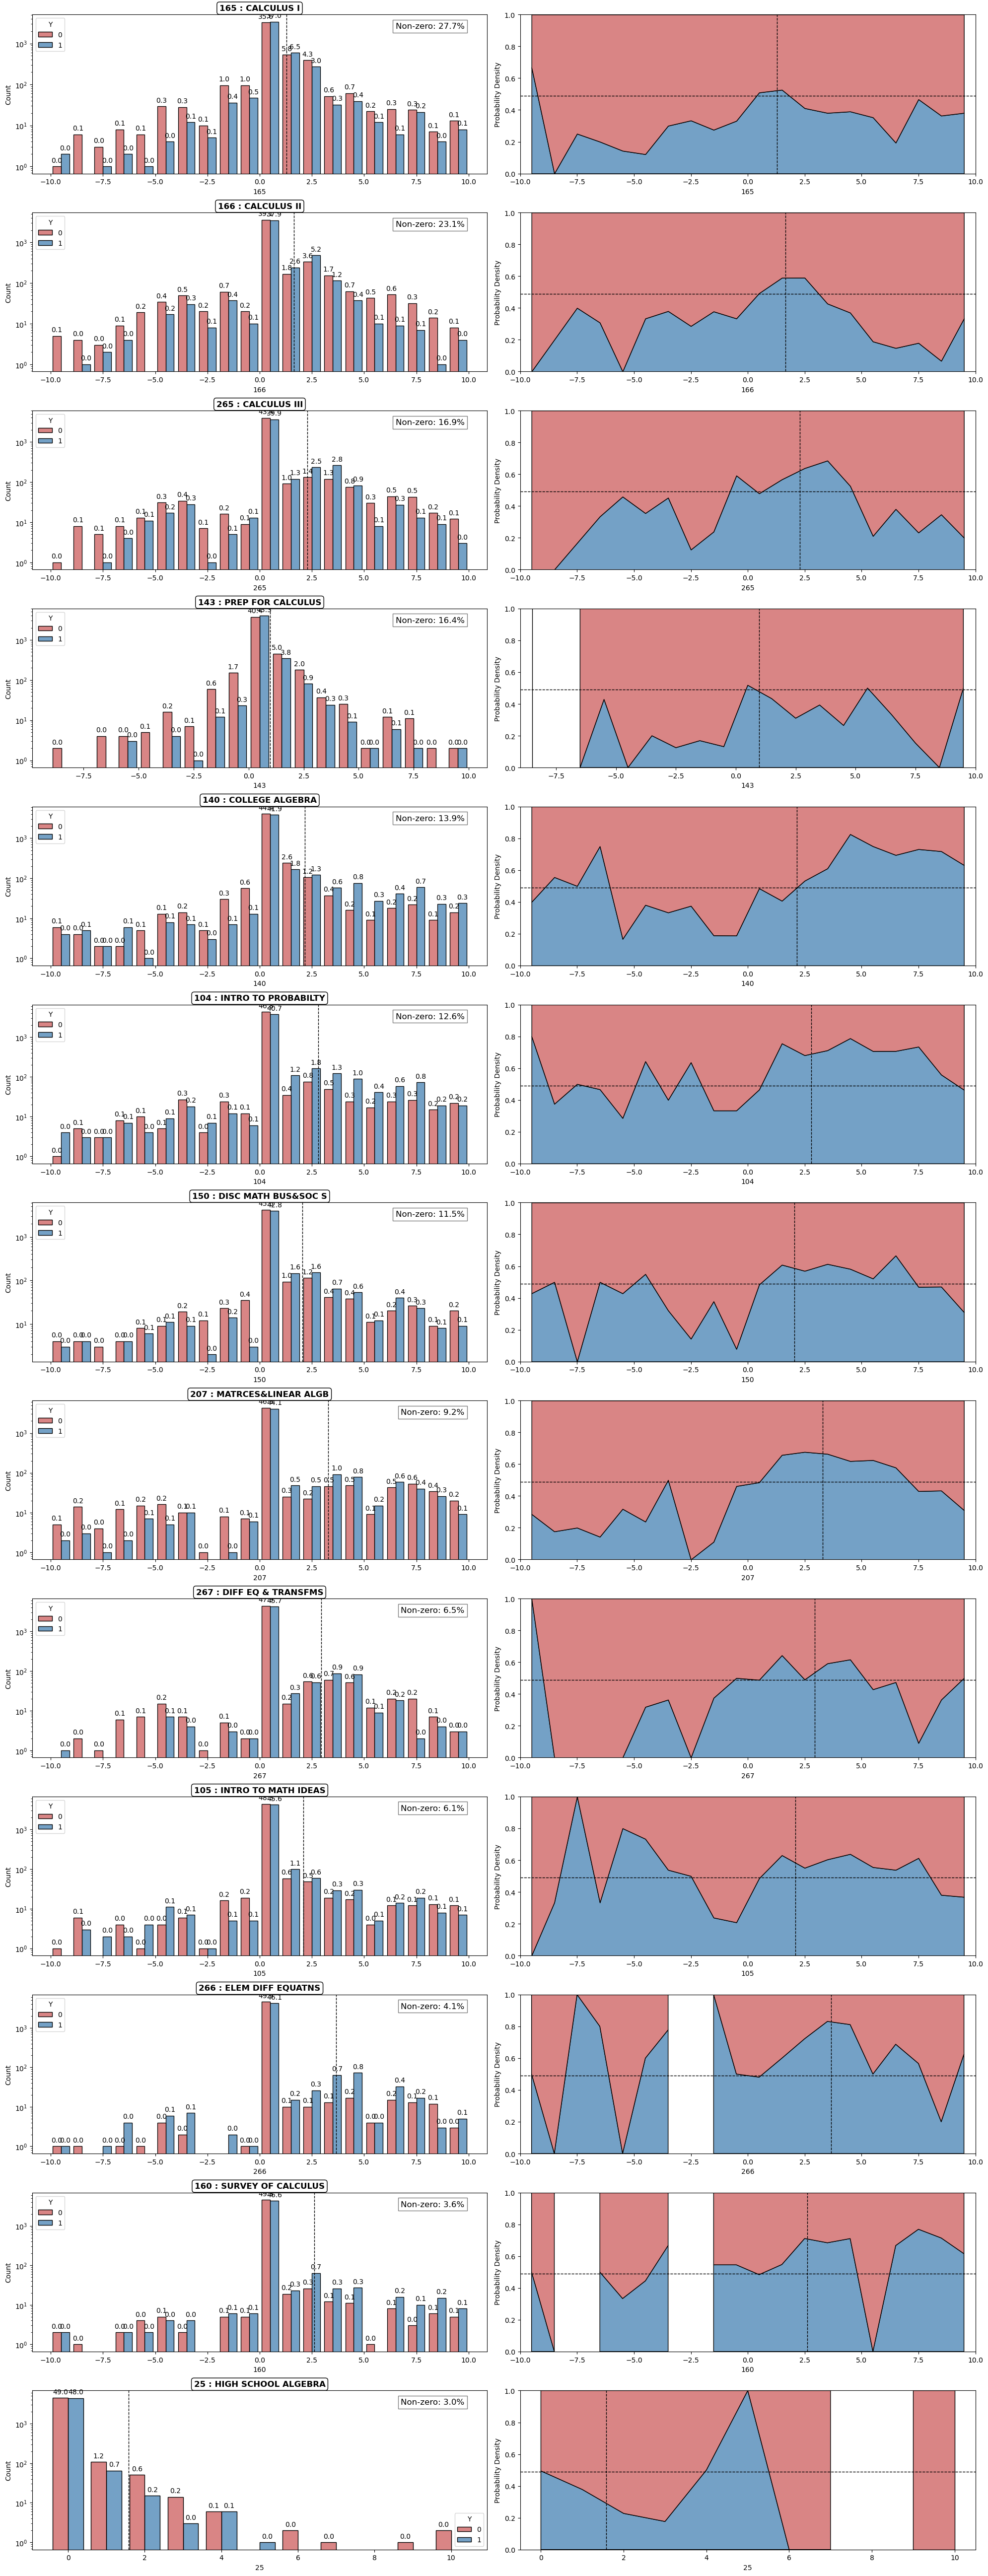

In [218]:
fig, axes = plt.subplots(len(gen_courses), 2, figsize=(20, len(gen_courses)*4))
# xticks = [-9.5, -4.5, -2, -1, 0, 1, 2, 4.5, 9.5]

for i, course in enumerate(gen_courses):
    non_zero_values_mean = df[course][df[course] != 0].mean()
    non_zero_percentage = ((df[course] != 0).sum() / len(df)) * 100
    
    # Plot histogram of raw counts with gaps between bars
    hist_data = sns.histplot(data=df, 
                             x=course, 
                             hue='Y', 
                             multiple='dodge',
                             palette=palette, 
                             ax=axes[i, 0],
                             discrete=True,
                             shrink=0.8)  # Add gap between bars
    axes[i, 0].axvline(non_zero_values_mean, color='black', linestyle='dashed', linewidth=1)
    # axes[i, 0].set_xticks(xticks)
    axes[i, 0].set_yscale('log')  # Set y-scale to log
    
    # Add a box displaying the percentage of non-zero values
    axes[i, 0].text(0.95, 0.95, f'Non-zero: {non_zero_percentage:.1f}%', 
                    transform=axes[i, 0].transAxes, fontsize=12,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.5))
    
    # Calculate and display the combined percentage of students in each bin
    total_counts = len(df)
    for p in hist_data.patches:
        height = p.get_height()
        if height > 0:
            percentage = f'{height / total_counts * 100:.1f}'
            axes[i, 0].annotate(percentage, 
                                (p.get_x() + p.get_width() / 2., height), 
                                ha='center', va='center', 
                                xytext=(0, 9), 
                                textcoords='offset points', 
                                fontsize=10, color='black')
    
    # Plot probability density
    sns.histplot(data=df, 
                 x=course, 
                 hue='Y', 
                 element='poly',
                 palette=palette, 
                 ax=axes[i, 1], 
                 multiple='fill',
                 discrete=True)
    axes[i, 1].set_ylabel('Probability Density')
    axes[i, 1].axvline(non_zero_values_mean, color='black', linestyle='dashed', linewidth=1)
    axes[i, 1].axhline(grad_rate, color='black', linestyle='dashed', linewidth=1)
    # axes[i, 1].set_xticks(xticks)
    #remove legend from right subplot
    axes[i, 1].get_legend().remove()
    
    # Add a single title for each row, centered at the top of the row
    axes[i, 0].set_title(f'{course} : {crse_dict[course]}', loc='center', fontsize=12, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
# plt.savefig('gen_histograms_density.png')
plt.show()

We can identify a few trends from these graphs, but the heavy imbalance in values makes it difficult draw reasonable inferences.

Indeed, the value 0 (indicating that the course was not taken) dominates all the graphs. So, the varying probabilities on the right are not very informative, since the corresponding bin counts tend to be very small (often less than 0.5% of the dataset).

Furthermore, among the students who did take a course, there is again an imbalance, with most of them passing the course. 

To get a better picture, let's replace all negative values with -1 (i.e., we count only the students who failed the course and ignore the semester). We replace the positive values (which simply equal the semester in which the course was taken) with the year in which the course was taken. 

/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_64713/3268657204.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_copy[courses] = df_copy[courses].applymap(lambda x: sem_to_year(x))


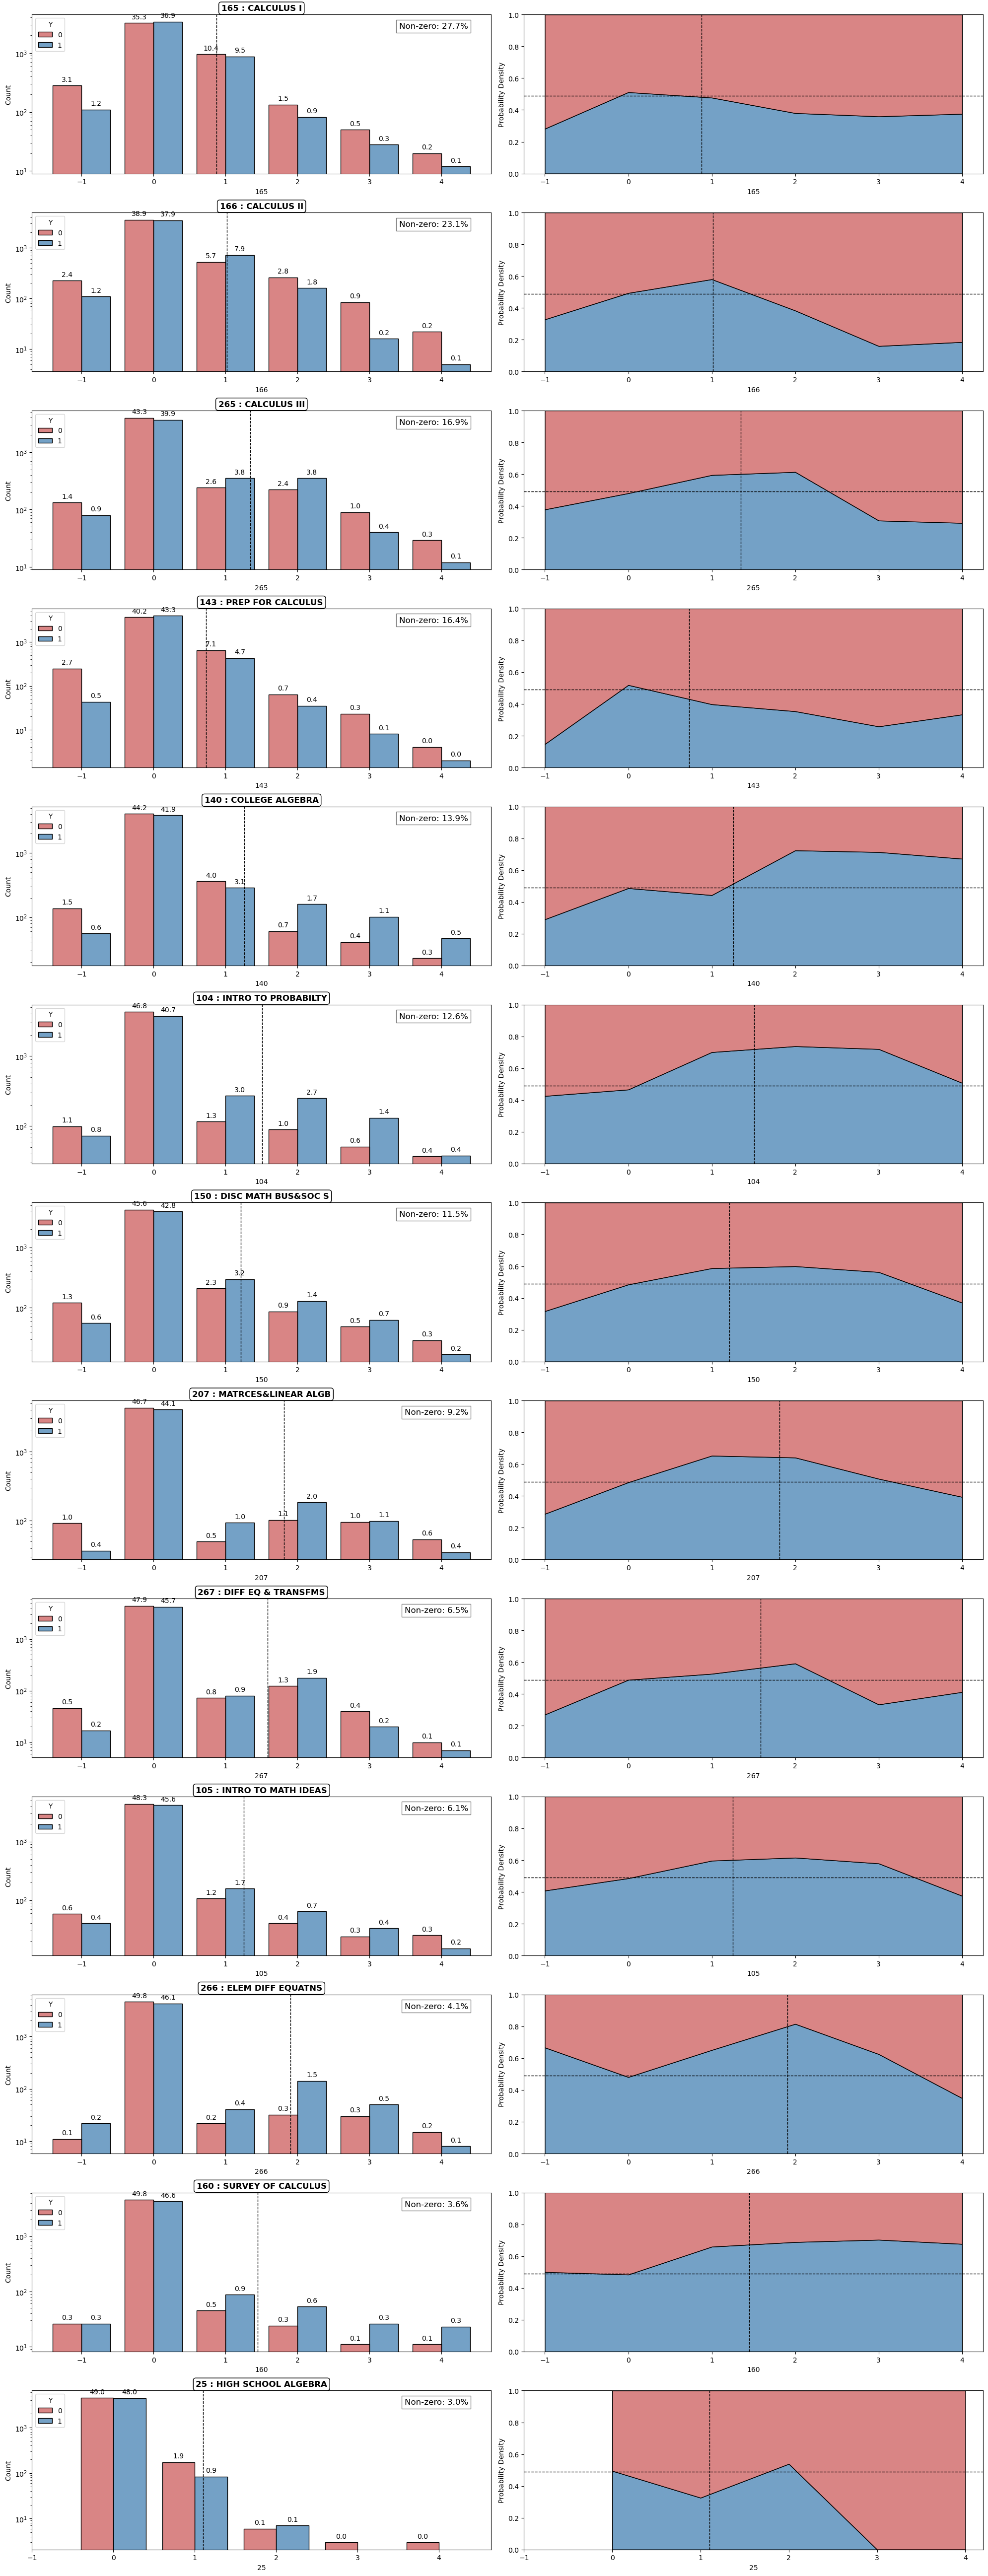

In [219]:
df_copy = df.copy()

def sem_to_year(sem):
    if sem < 0:
        return -1
    else:
        return np.ceil(sem*0.4)

df_copy[courses] = df_copy[courses].applymap(lambda x: sem_to_year(x))

fig, axes = plt.subplots(len(gen_courses), 2, figsize=(20, len(gen_courses)*4))
xticks = [-1,0,1,2,3,4]

for i, course in enumerate(gen_courses):
    non_zero_values_mean = df_copy[course][df_copy[course] != 0].mean()
    non_zero_percentage = ((df_copy[course] != 0).sum() / len(df_copy)) * 100
    
    # Plot histogram of raw counts with gaps between bars
    hist_data = sns.histplot(data=df_copy, 
                             x=course, 
                             hue='Y', 
                             multiple='dodge',
                             palette=palette, 
                             ax=axes[i, 0],
                             discrete=True,
                             shrink=0.8)  # Add gap between bars
    axes[i, 0].axvline(non_zero_values_mean, color='black', linestyle='dashed', linewidth=1)
    axes[i, 0].set_xticks(xticks)
    axes[i, 0].set_yscale('log')  # Set y-scale to log
    
    # Add a box displaying the percentage of non-zero values
    axes[i, 0].text(0.95, 0.95, f'Non-zero: {non_zero_percentage:.1f}%', 
                    transform=axes[i, 0].transAxes, fontsize=12,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.5))
    
    # Calculate and display the combined percentage of students in each bin
    total_counts = len(df_copy)
    for p in hist_data.patches:
        height = p.get_height()
        if height > 0:
            percentage = f'{height / total_counts * 100:.1f}'
            axes[i, 0].annotate(percentage, 
                                (p.get_x() + p.get_width() / 2., height), 
                                ha='center', va='center', 
                                xytext=(0, 9), 
                                textcoords='offset points', 
                                fontsize=10, color='black')
    
    # Plot probability density
    sns.histplot(data=df_copy, 
                 x=course, 
                 hue='Y', 
                 element='poly',
                 palette=palette, 
                 ax=axes[i, 1], 
                 multiple='fill',
                 discrete=True)
    axes[i, 1].set_ylabel('Probability Density')
    axes[i, 1].axvline(non_zero_values_mean, color='black', linestyle='dashed', linewidth=1)
    axes[i, 1].axhline(grad_rate, color='black', linestyle='dashed', linewidth=1)
    axes[i, 1].set_xticks(xticks)
    #remove legend from right subplot
    axes[i, 1].get_legend().remove()
    
    # Add a single title for each row, centered at the top of the row
    axes[i, 0].set_title(f'{course} : {crse_dict[course]}', loc='center', fontsize=12, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.savefig('Plots/gen_courses_hist_density.png')
plt.show()

### Observations on how performance in general math courses affects probability of graduating in 9.5 semesters.

For each course $C$, the possible values are $x \in \{-1,0,1,2,3,4\}$:

- $C=-1$ indicates fail (i.e., getting a C- or below);
- $C=0$ indicates the course was not taken; 
- $C = x>0$ indicates that the course was taken and passed in year $x$. 

Let $g(C = x)$ denote the grad rate among students for which $C=x$; this is nothing but the conditional probability $Pr(Y=1|C=x)$. 

The horizontal lines on the right denote the overall grad rate for the dataset, i.e., it is the unconditional probability $\hat{g} = Pr(Y=1) ~ 0.49$.

The vertical lines on the right denote the mean among the positive values of $C$, that is, it equals the conditional expectation $E(C|C>0)$.

1. For all the courses except 266 (ELEM DIFF EQ), we have $$g(C=-1) < \hat{g}.$$
Thus, failing the course is correlated with lower odds of graduating in 4 years.

2. The courses $143$ (PREP FOR CALCULUS) and $165$ (CALCULUS 1) exhibit an interesting phenomenon-- we have
\begin{equation*} g(C=0) < \hat{g}. \end{equation*} 
That is, **not** taking these courses is correlated with a better than overage chance of graduating in 4 years. One possible explanation for this is that, among those students majoring in a subject that requires calculus, students who take these courses in college are less mathematically prepared than those who do not (i.e., who took calculus/pre-calculus in high school). 

3. For most of the courses, there is a visible "hill" trend with a peak and downward slopes on either side. For example, for $166$ (CALCULUS II), we find that $g(C=1) > \hat{g}$ (the peak), and $g(C=x)$ gets smaller as $x$ is further away from $1$. 

    Similarly, for the course $265$ (CALCULUS III). We have $g(C=1,2) > \hat{g}$, whereas $g(C = x) < \hat{g}$ if $x=-1,0,3,4$. 

    The take-away from these trends is that graduating in 4 years appears to be correlated not simply with taking the course, but with taking the course "sufficiently early". 

4. The graph for 140 (COLLEGE ALGEBRA) appears to be rather mysterious and counter-intuitive, because it shows that $g(C = x) > \hat{g}$ when $x=2,3,4$. It is not clear why taking college algebra in the last 3 years is correlated with increased odds of Y=1.

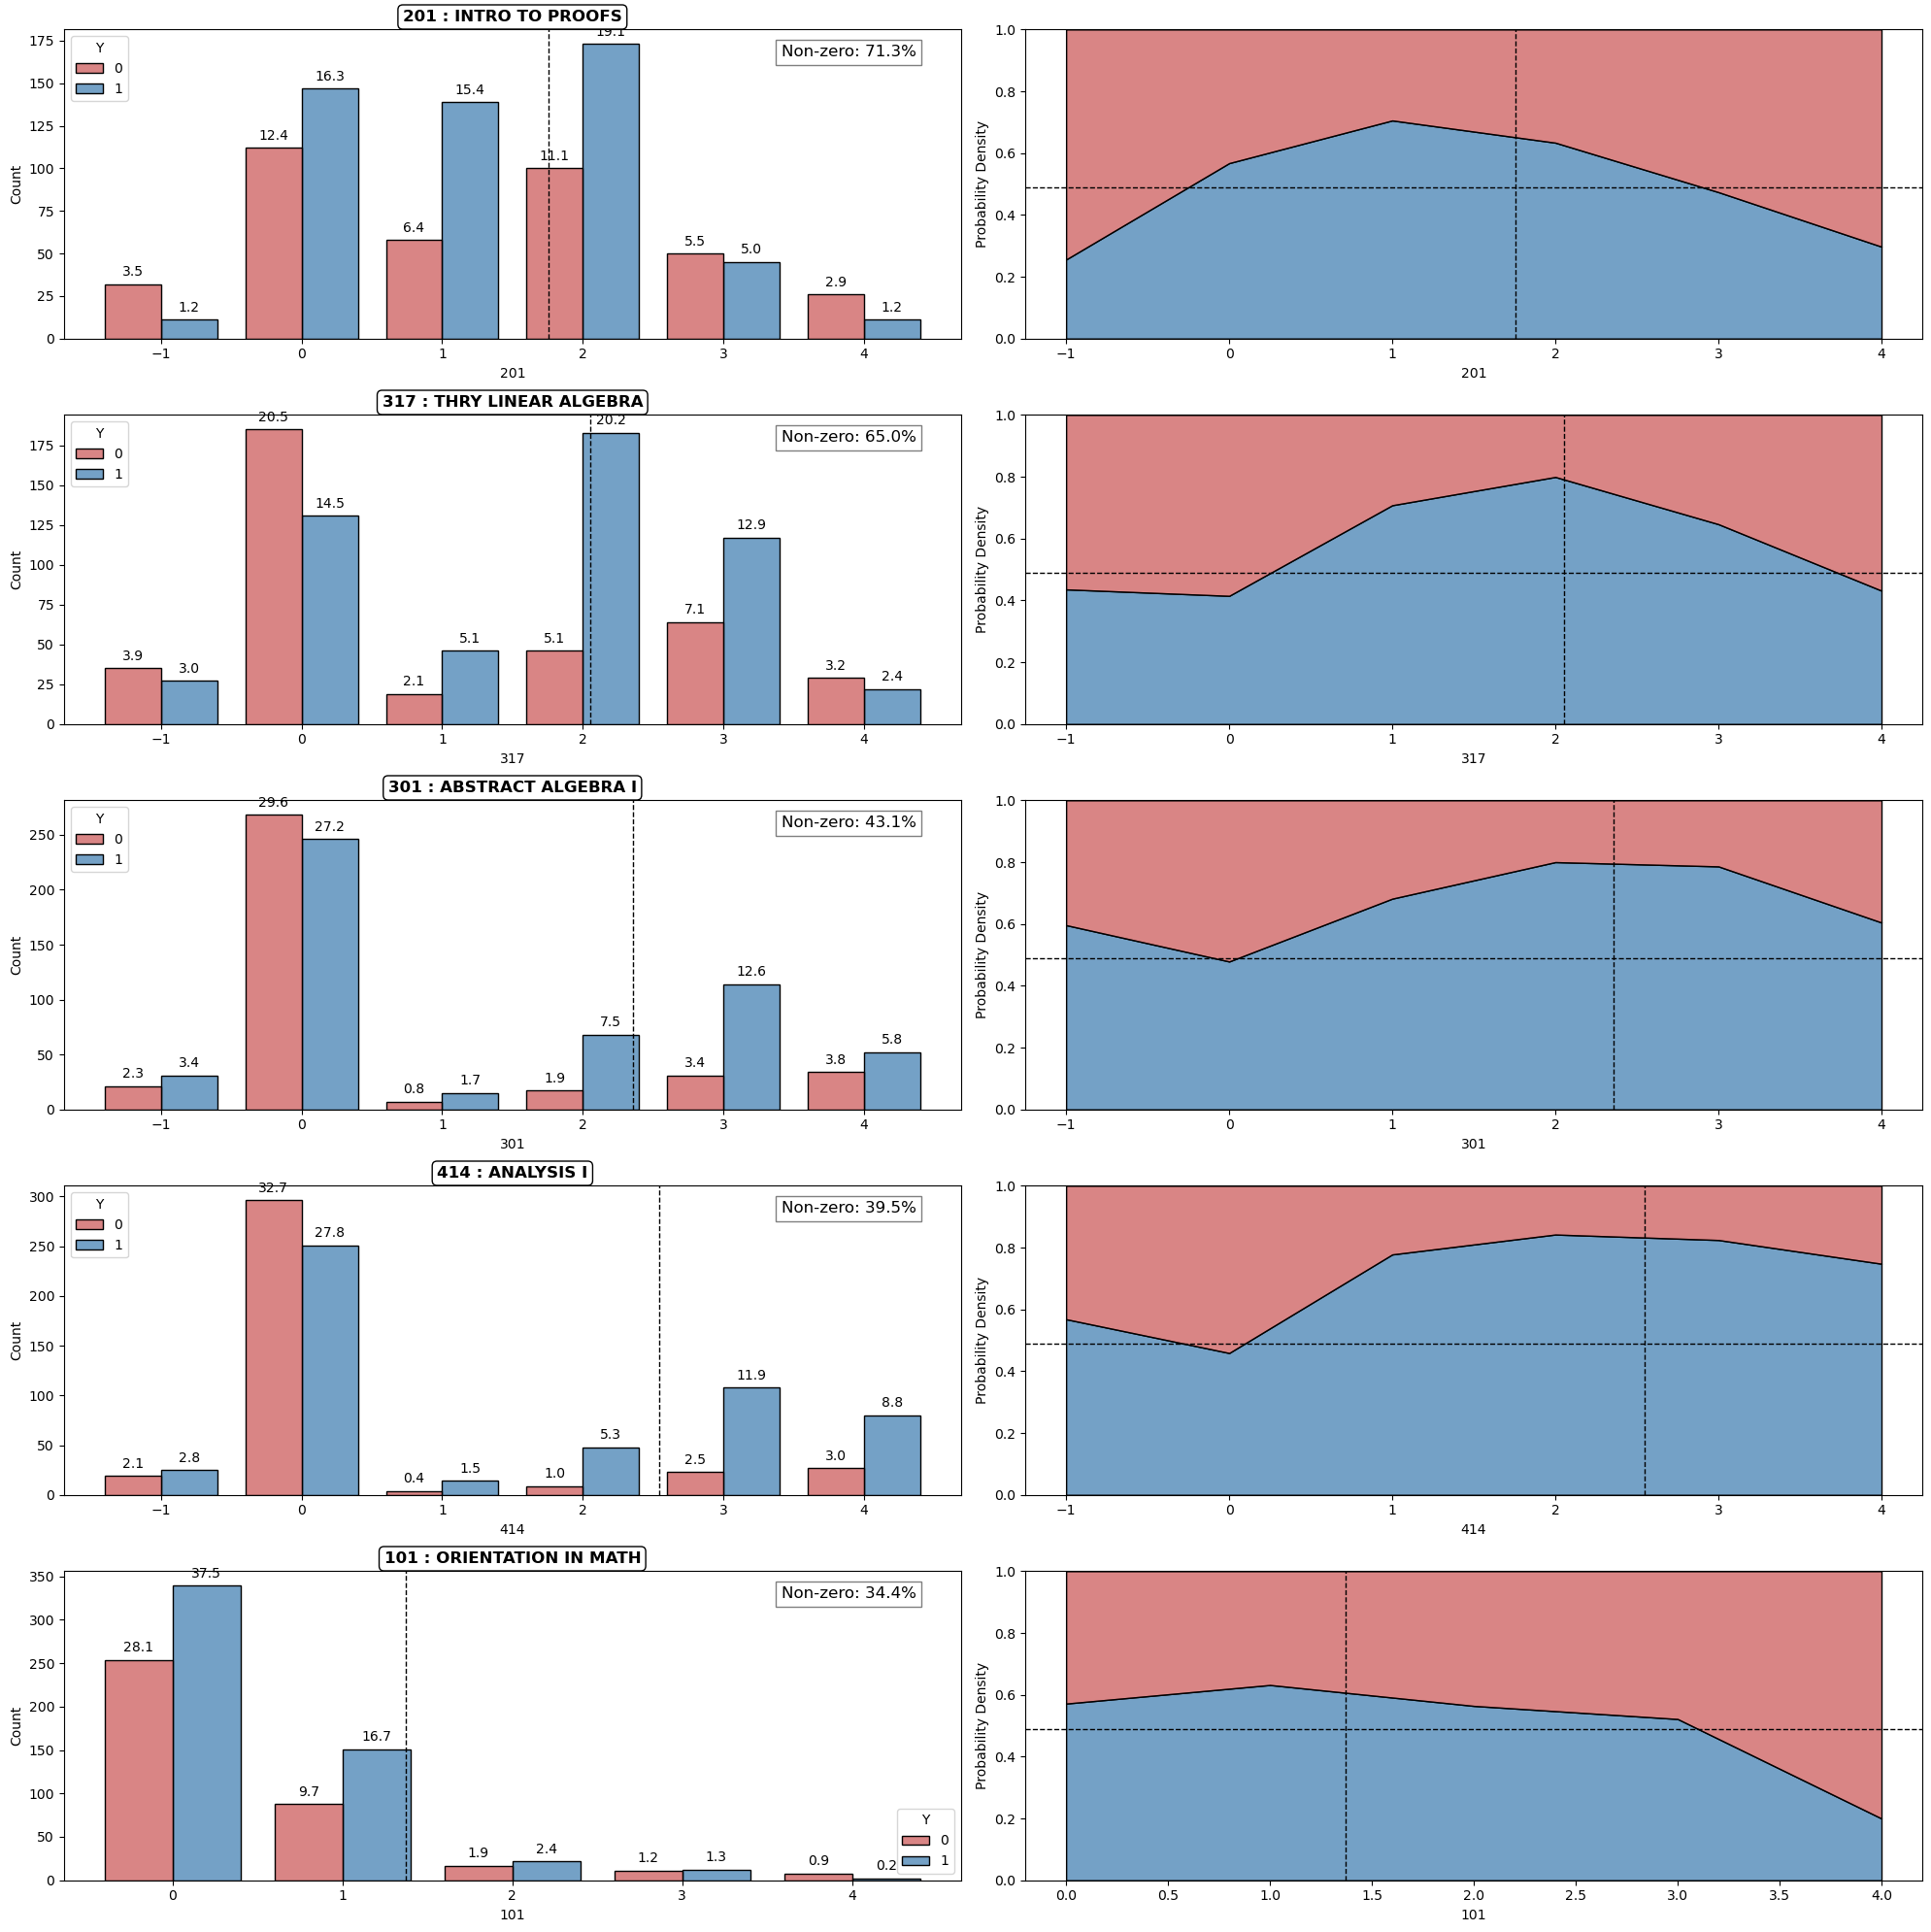

In [220]:
df_math_copy = df_copy[df_copy[math_courses].abs().sum(axis=1) > 0]

fig, axes = plt.subplots(len(math_courses), 2, figsize=(20, len(math_courses)*4))

for i, course in enumerate(math_courses):
    non_zero_values_mean = df_math_copy[course][df_math_copy[course] != 0].mean()
    non_zero_percentage = ((df_math_copy[course] != 0).sum() / len(df_math_copy)) * 100    
    
    # Plot histogram of raw counts with gaps between bars
    hist_data = sns.histplot(data=df_math_copy, 
                             x=course, 
                             hue='Y', 
                             multiple='dodge',
                             palette=palette, 
                             ax=axes[i, 0],
                             discrete=True,
                             shrink=0.8)  # Add gap between bars
    axes[i, 0].axvline(non_zero_values_mean, color='black', linestyle='dashed', linewidth=1)
    # axes[i, 0].set_yscale('log')  # Set y-scale to log
    
    # Add a box displaying the percentage of non-zero values
    axes[i, 0].text(0.95, 0.95, f'Non-zero: {non_zero_percentage:.1f}%', 
                    transform=axes[i, 0].transAxes, fontsize=12,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.5))
    
    # Calculate and display the combined percentage of students in each bin
    total_counts = len(df_math_copy)
    for p in hist_data.patches:
        height = p.get_height()
        if height > 0:
            percentage = f'{height / total_counts * 100:.1f}'
            axes[i, 0].annotate(percentage, 
                                (p.get_x() + p.get_width() / 2., height), 
                                ha='center', va='center', 
                                xytext=(0, 9), 
                                textcoords='offset points', 
                                fontsize=10, color='black')
    
    # Plot probability density
    sns.histplot(data=df_math_copy, 
                 x=course, 
                 hue='Y', 
                 element='poly',
                 palette=palette, 
                 ax=axes[i, 1], 
                 multiple='fill',
                 discrete=True)
    axes[i, 1].set_ylabel('Probability Density')
    axes[i, 1].axvline(non_zero_values_mean, color='black', linestyle='dashed', linewidth=1)
    axes[i, 1].axhline(grad_rate, color='black', linestyle='dashed', linewidth=1)
    #remove legend from right subplot
    axes[i, 1].get_legend().remove()
    
    # Add a single title for each row, centered at the top of the row
    axes[i, 0].set_title(f'{course} : {crse_dict[course]}', loc='center', fontsize=12, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.savefig('Plots/math_course_hist_density.png')
plt.show()

### Observations on how performance in math major courses affects probability of graduating in 9.5 semesters.

1. The courses 201 (INTRO TO PROOFS), 314 (THRY LINEAR ALGEBRA) and 101 (ORIENTATION IN MATH) exhibit the same "hill" trend that appeared for most of the general math courses-- we have $g(C = x) > \hat{g}$ if the course is taken "early enough", and $g(C = x) < \hat{g}$ if the student fails the course or takes it too late.

2. The courses 301 (ABSTRACT ALGEBRA I) and 414 (ANALYSIS I) appear to show a different, interesting trend-- we have $g(C = x) > \hat{g}$ if and $x \neq 0$. In particular, $g(C = -1) > \hat{g}$, indicating that simply taking these courses (and ignoring passing or failing) itself is correlated with better than average odds of graduating in 4 years. This is perhaps not very surprising given that these are more advanced math courses, and students who take these have progressed far enough in their major that they are on track to graduate in 4 years even if they fail these courses.

Next, we create some continuous-ish features which are designed to measure the students' academic performance as follows:

1. For each semester $i$ in the list of semesters `sems` (multiples of $0.5$ starting with $0.5$ and ending in $9.5$), we count the number of general, math, and combined courses that were passed, and we subtract from each the number that were failed. We store these values in columns names `SEM_i`, `SEM_i_MATH`, and `SEM_i_GEN` respectively.

    For example, if a student has `SEM_2.0` equal to $1$, then they passed 2 courses more than they failed in semester 2. 

2. Then, we compute the cumulative sums of the above columns as $i$ ranges over the semesters. These are stored in columns named `SEM_i_cdf`, `SEM_i_MATH_cdf`, and `SEM_i_GEN_cdf`, respectively. 

    For example, if a student has `SEM_4.5_cdf` equal to $3$, then they within the first 4.5 semesters, the student passed $3$ courses more than they failed. 

    In particular, the columns `SEM_9.5_cdf`, `SEM_9.5_MATH_cdf`, and `SEM_9.5_GEN_cdf` measure the students performance at the end of the four year period under consideration. 

3. Next, for the overall, general course, and math major course performances, we compute lines of best fit for their cumulative performance. These lines capture the "trend" of the students' academic performance across the semesters. 

    For example, if the trend line for a students math-major-course performance is sloping upwards, then it indicates that the student accumulated more passes in math-major-courses as time passed.

3. We store the slope and intercept of each regression line in new columns (`INT` and `SLOPE` for the overall performance, `INT_MATH` and `SLOPE_MATH` for the math-major-course performance, and `INT_GEN` and `SLOPE_GEN` for the general course performance).

In [180]:
crse_counts = pd.read_csv('crse_counts.csv')
courses = [str(x) for x in list(crse_counts['CRSE'])]
gen_courses = [c for c in courses if c in gen_dict.keys()]
math_courses = [c for c in courses if c in math_dict.keys()]

In [181]:
sems = [0.5*i for i in range(1, 20)]

# Create a DataFrame for SEM columns
sem_df = pd.concat([df[courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'SEM_{i}') for i in sems], axis=1)
sem_math_df = pd.concat([df[math_courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'SEM_{i}_MATH') for i in sems], axis=1)
sem_gen_df = pd.concat([df[gen_courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'SEM_{i}_GEN') for i in sems], axis=1)

# # Add the SEM columns to the original DataFrame
# df = pd.concat([df, sem_df], axis=1)

# Define columns for the cumulative sums of math performance
df[[f'SEM_{i}_cdf' for i in sems]] = sem_df.cumsum(axis=1)
df[[f'SEM_{i}_MATH_cdf' for i in sems]] = sem_math_df.cumsum(axis=1)
df[[f'SEM_{i}_GEN_cdf' for i in sems]] = sem_gen_df.cumsum(axis=1)

df['SLOPE'] = 0.0
df['INT'] = 0.0
df['SlOPE_MATH'] = 0.0
df['INT_MATH'] = 0.0
df['SLOPE_GEN'] = 0.0
df['INT_GEN'] = 0.0

# Loop through the rows of the DataFrame
x = sems
for i, row in df.iterrows():
    #y values
    y = row[[f'SEM_{j}_cdf' for j in sems]].astype(float)
    y_math = row[[f'SEM_{j}_MATH_cdf' for j in sems]].astype(float)
    y_gen = row[[f'SEM_{j}_GEN_cdf' for j in sems]].astype(float)
    # Calculate the slope and intercept
    S, I = np.polyfit(x, y, 1)
    S_math, I_math = np.polyfit(x, y_math, 1)
    S_gen, I_gen = np.polyfit(x, y_gen, 1)
    # Store the values in the original DataFrame
    df.at[i, 'SLOPE'] = S
    df.at[i, 'INT'] = I
    df.at[i, 'SLOPE_MATH'] = S_math
    df.at[i, 'INT_MATH'] = I_math
    df.at[i, 'SLOPE_GEN'] = S_gen
    df.at[i, 'INT_GEN'] = I_gen

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


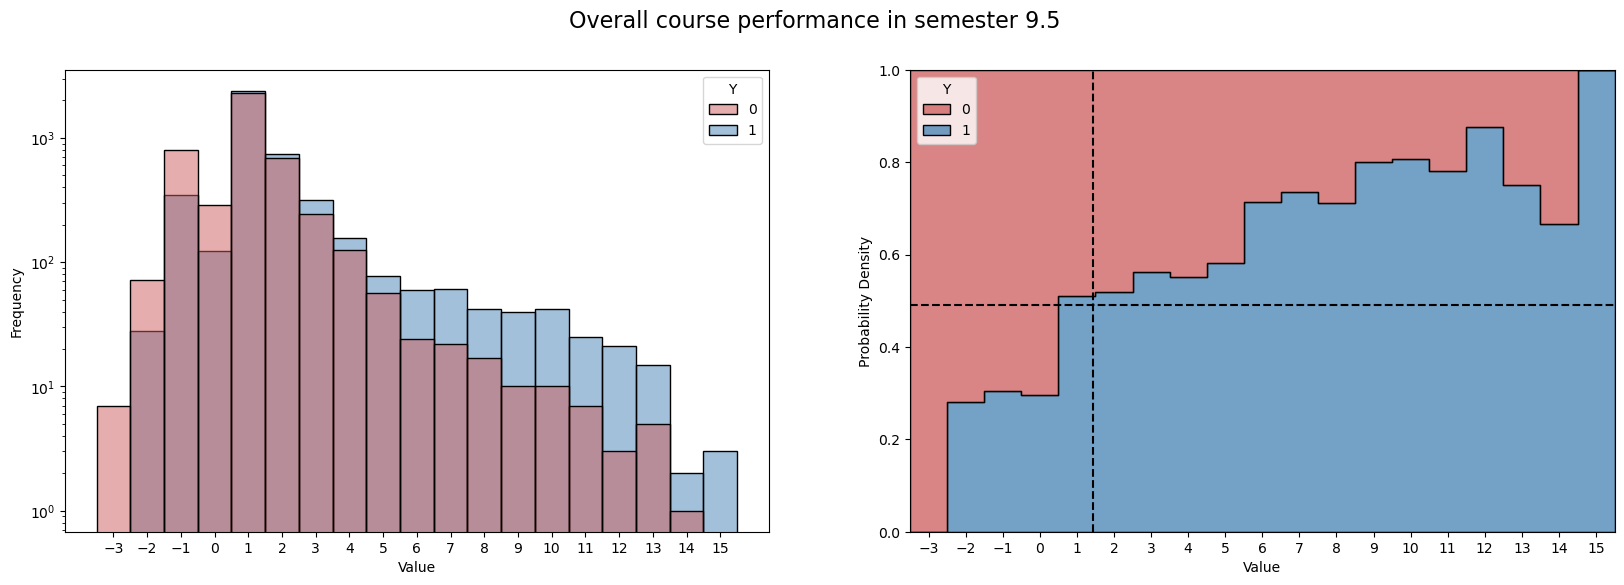

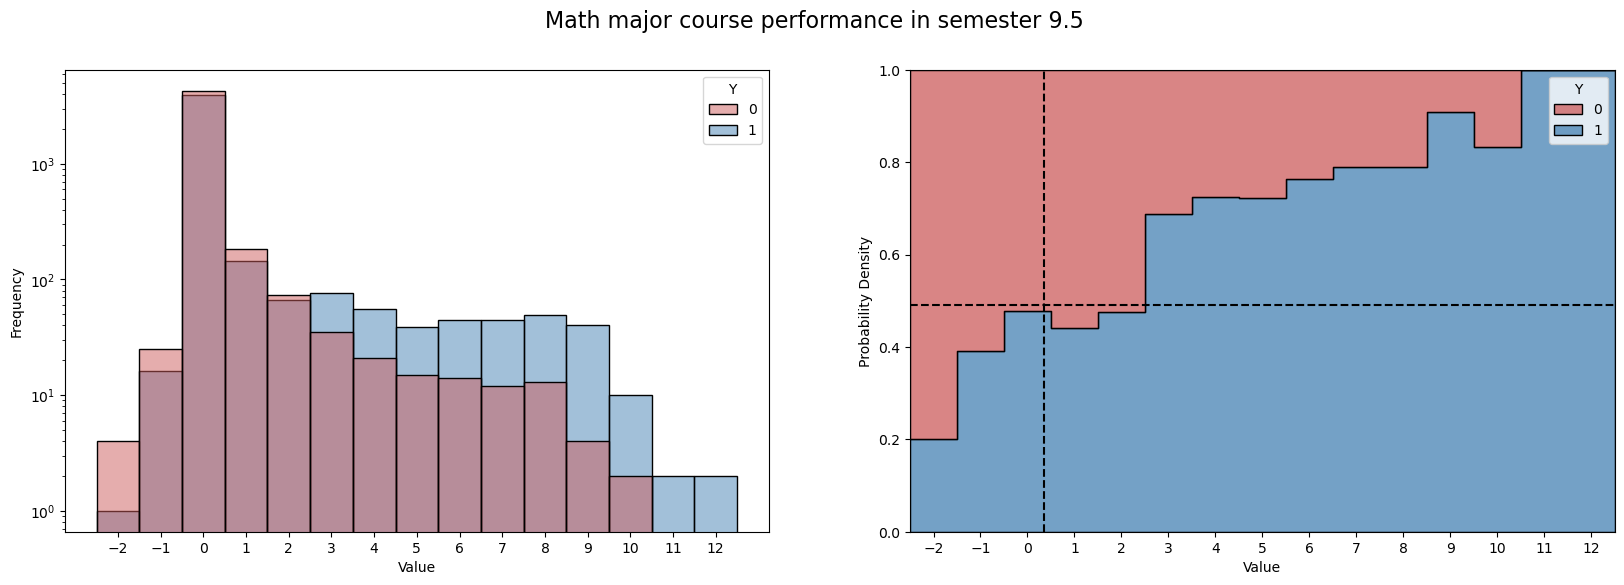

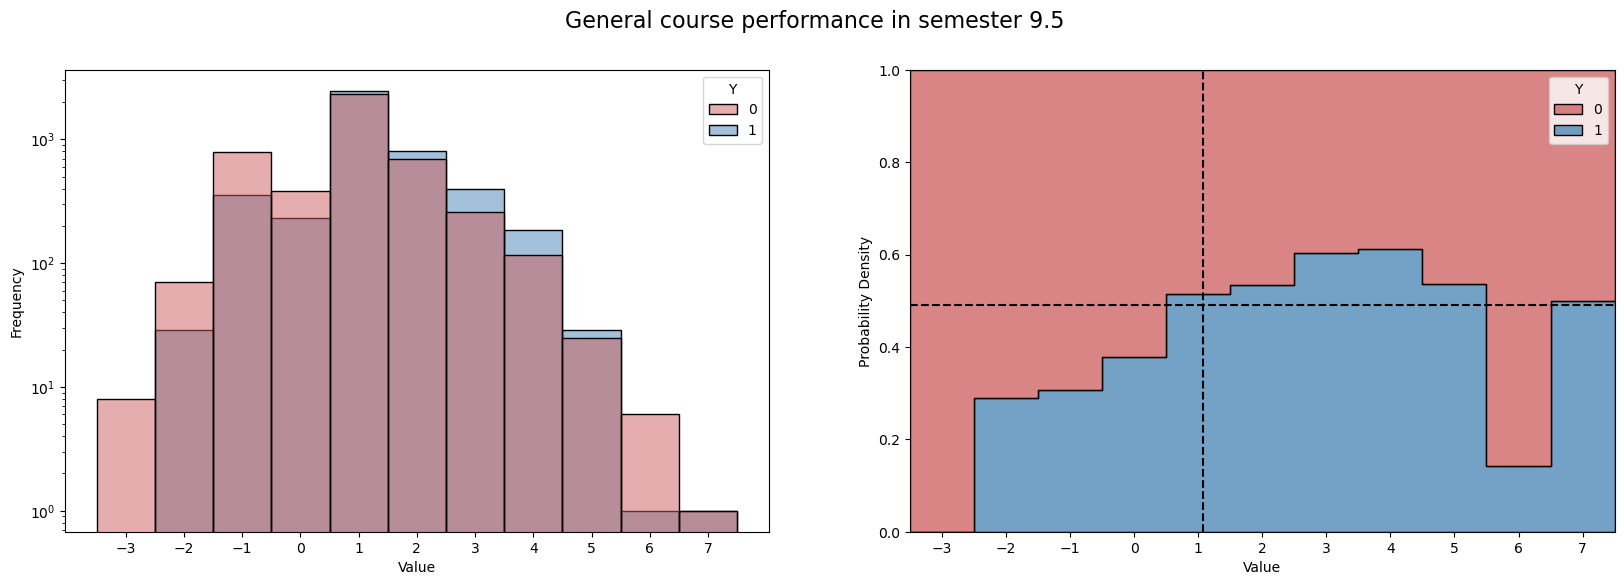

In [182]:
from matplotlib.animation import FuncAnimation

def animate_histograms(dataframe,
                       data_series, 
                       titles,
                       timeperiods,
                       suptitle,  
                       unique_values,
                       interval=300,):
    """
    Animate multiple histograms
    
    Parameters:
    data_series: List of arrays to plot
    titles: List of titles for each histogram
    interval: Animation interval in milliseconds
    """
    
    # Setup the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    def update(frame):
        for ax in axes:
            ax.clear()
        
        # Plot histogram for raw counts
        sns.histplot(data=dataframe, 
                     x=data_series[frame], 
                     hue='Y', 
                     multiple='layer', 
                     palette=palette, 
                     ax=axes[0], 
                     discrete=True)
        axes[0].set_yscale('log')
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Frequency')
        axes[0].set_xticks(unique_values)
        
        # Plot histogram for probability densities
        sns.histplot(data=dataframe, 
                     x=data_series[frame], 
                     hue='Y', 
                     multiple='fill', 
                     element='step', 
                     palette=palette, 
                     ax=axes[1], 
                     discrete=True)
        axes[1].axhline(grad_rate, color='black', linestyle='--')
        axes[1].set_xlabel('Value')
        axes[1].set_ylabel('Probability Density')
        axes[1].set_xticks(unique_values)
        #draw a vertical line at the mean of the data
        axes[1].axvline(data_series[frame].mean(), color='black', linestyle='--')
        
        # Add a common title
        fig.suptitle(f"{suptitle} {timeperiods[frame]}", fontsize=16)
    
    # Create animation
    anim = FuncAnimation(fig, update,
                         frames=len(data_series),
                         interval=interval,
                         repeat=True)
    
    # Save the animation
    return anim
    # anim.save('cdf_animation.gif', writer='Pillow')

#use the function anime_histogram to animate the histograms of the cumulative number of courses taken in each semester
animate_histograms(dataframe=df,
                   data_series = [df[f'SEM_{sem}_cdf'] for sem in sems],
                   titles = [f'SEM{sem}_cdf' for sem in sems],
                   timeperiods=sems,
                   suptitle = 'Overall course performance in semester',
                   unique_values = sorted(df['SEM_9.5_cdf'].unique())).save('cdf_animation.gif',writer='Pillow')

animate_histograms(dataframe=df,
                   data_series = [df[f'SEM_{sem}_MATH_cdf'] for sem in sems],
                   titles = [f'SEM_{sem}_MATH_cdf' for sem in sems],
                   timeperiods=sems,
                   suptitle = 'Math major course performance in semester',
                   unique_values = sorted(df['SEM_9.5_MATH_cdf'].unique())).save('cdf_animation_math.gif', writer='Pillow')

animate_histograms(dataframe=df,
                   data_series = [df[f'SEM_{sem}_GEN_cdf'] for sem in sems],
                   titles = [f'SEM_{sem}_GEN_cdf' for sem in sems],
                   timeperiods=sems,
                   suptitle = 'General course performance in semester',
                   unique_values = sorted(df['SEM_9.5_GEN_cdf'].unique())).save('cdf_animation_gen.gif', writer='Pillow')

Text(37.597222222222214, 0.5, 'SEM_9.5_cdf')

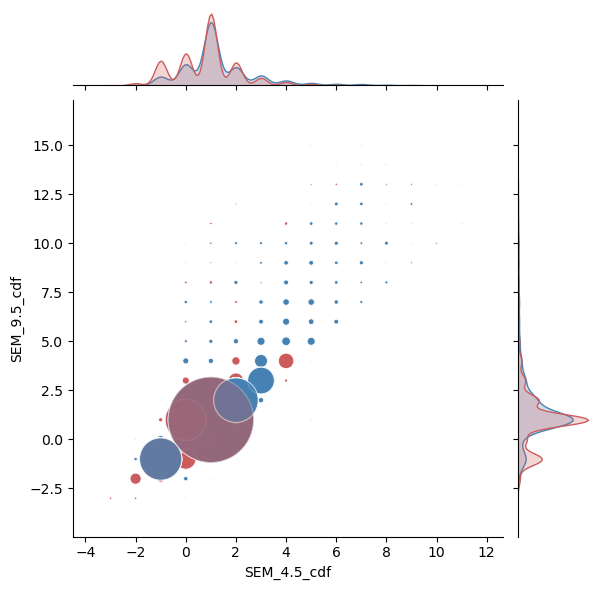

In [183]:
f1 = 'SEM_4.5_cdf'
f2 = 'SEM_9.5_cdf'
counts = df.groupby([f1, f2]).size().reset_index(name='counts')
merged_df = pd.merge(df, counts, on=[f1, f2])

# Normalize counts to range between 0.3 and 1 for transparency
norm_counts = 1 - 0.85*(merged_df['counts'] - merged_df['counts'].min()) / (merged_df['counts'].max() - merged_df['counts'].min())

sns.jointplot(x=f1, 
                y=f2, 
                data=merged_df, 
                hue='Y', 
                palette=palette,
                alpha=norm_counts,  # transparency varies with the count
                s=merged_df['counts'],  # size of the dot varies with the count
                legend=False)  # remove the legend from each subplot
plt.xlabel(f1)
plt.ylabel(f2)


In [184]:
#check how many students took a math major course
df_math = df[df[math_courses].abs().sum(axis=1) > 0]
df_nonmath = df[df[math_courses].abs().sum(axis=1) == 0]

In [185]:
df_math['Y'].mean(), df_nonmath['Y'].mean()

(np.float64(0.5857699805068226), np.float64(0.4776210913549969))

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


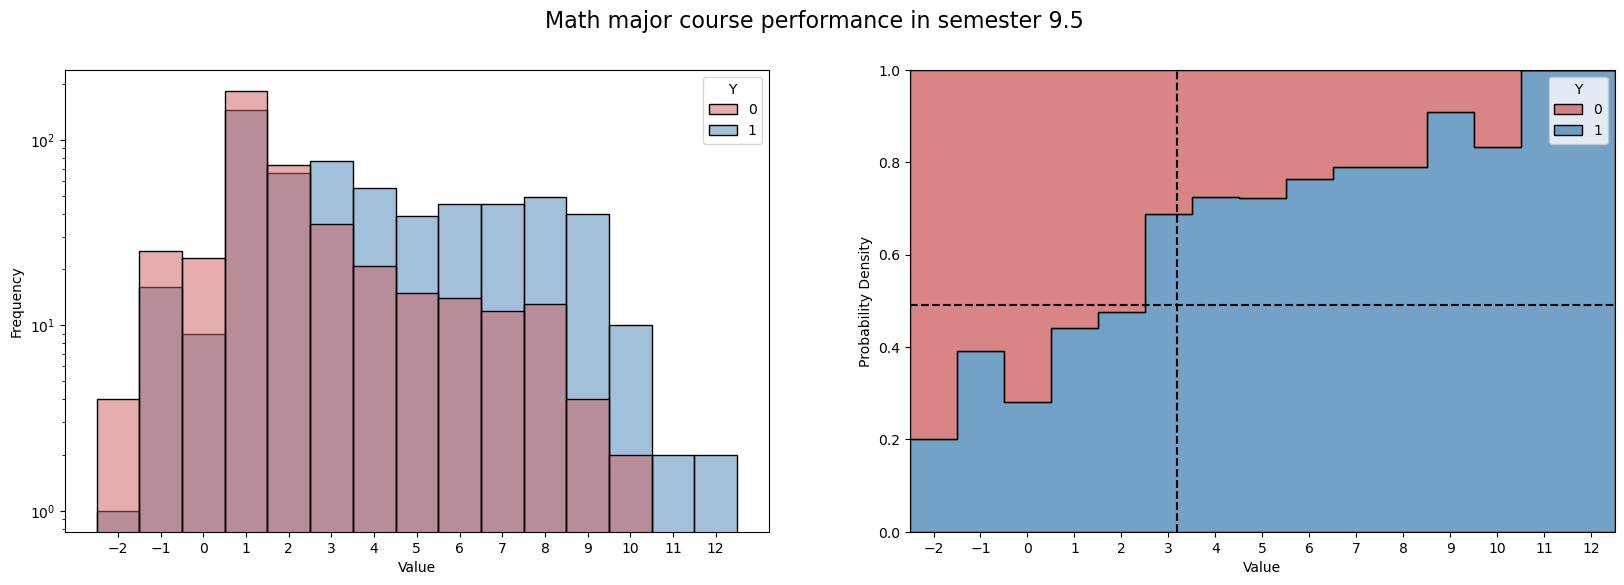

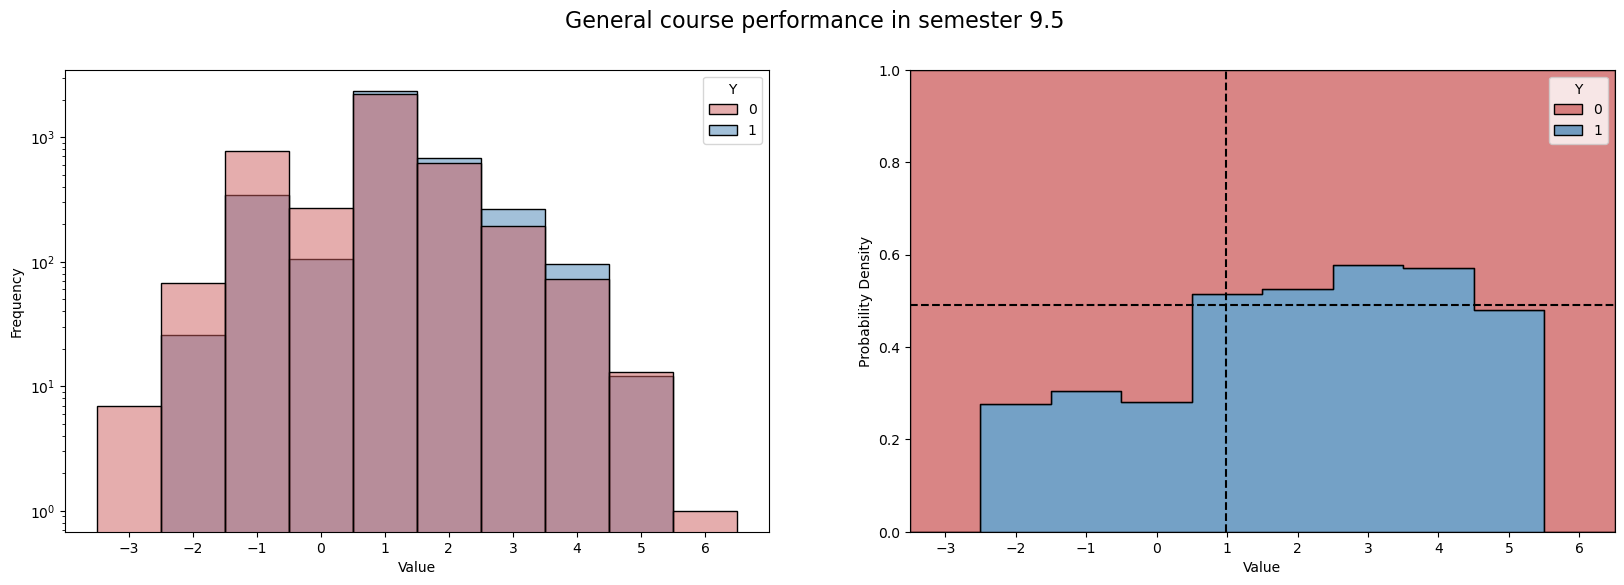

In [186]:
animate_histograms(dataframe=df_math,
                   data_series = [df_math[f'SEM_{sem}_MATH_cdf'] for sem in sems],
                   titles = [f'SEM_{sem}_MATH_cdf' for sem in sems],
                   timeperiods=sems,
                   suptitle = 'Math major course performance in semester',
                   unique_values = sorted(df_math['SEM_9.5_MATH_cdf'].unique())).save('math_cdf_animation_math.gif', writer='Pillow')

animate_histograms(dataframe=df_nonmath,
                   data_series = [df_nonmath[f'SEM_{sem}_GEN_cdf'] for sem in sems],
                   titles = [f'SEM_{sem}_GEN_cdf' for sem in sems],
                   timeperiods=sems,
                   suptitle = 'General course performance in semester',
                   unique_values = sorted(df_nonmath['SEM_9.5_GEN_cdf'].unique())).save('nonmath_cdf_animation_gen.gif', writer='Pillow')

/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_64713/2892702590.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_math_copy[courses] = df_math_copy[courses].applymap(lambda x: sem_to_year(x))


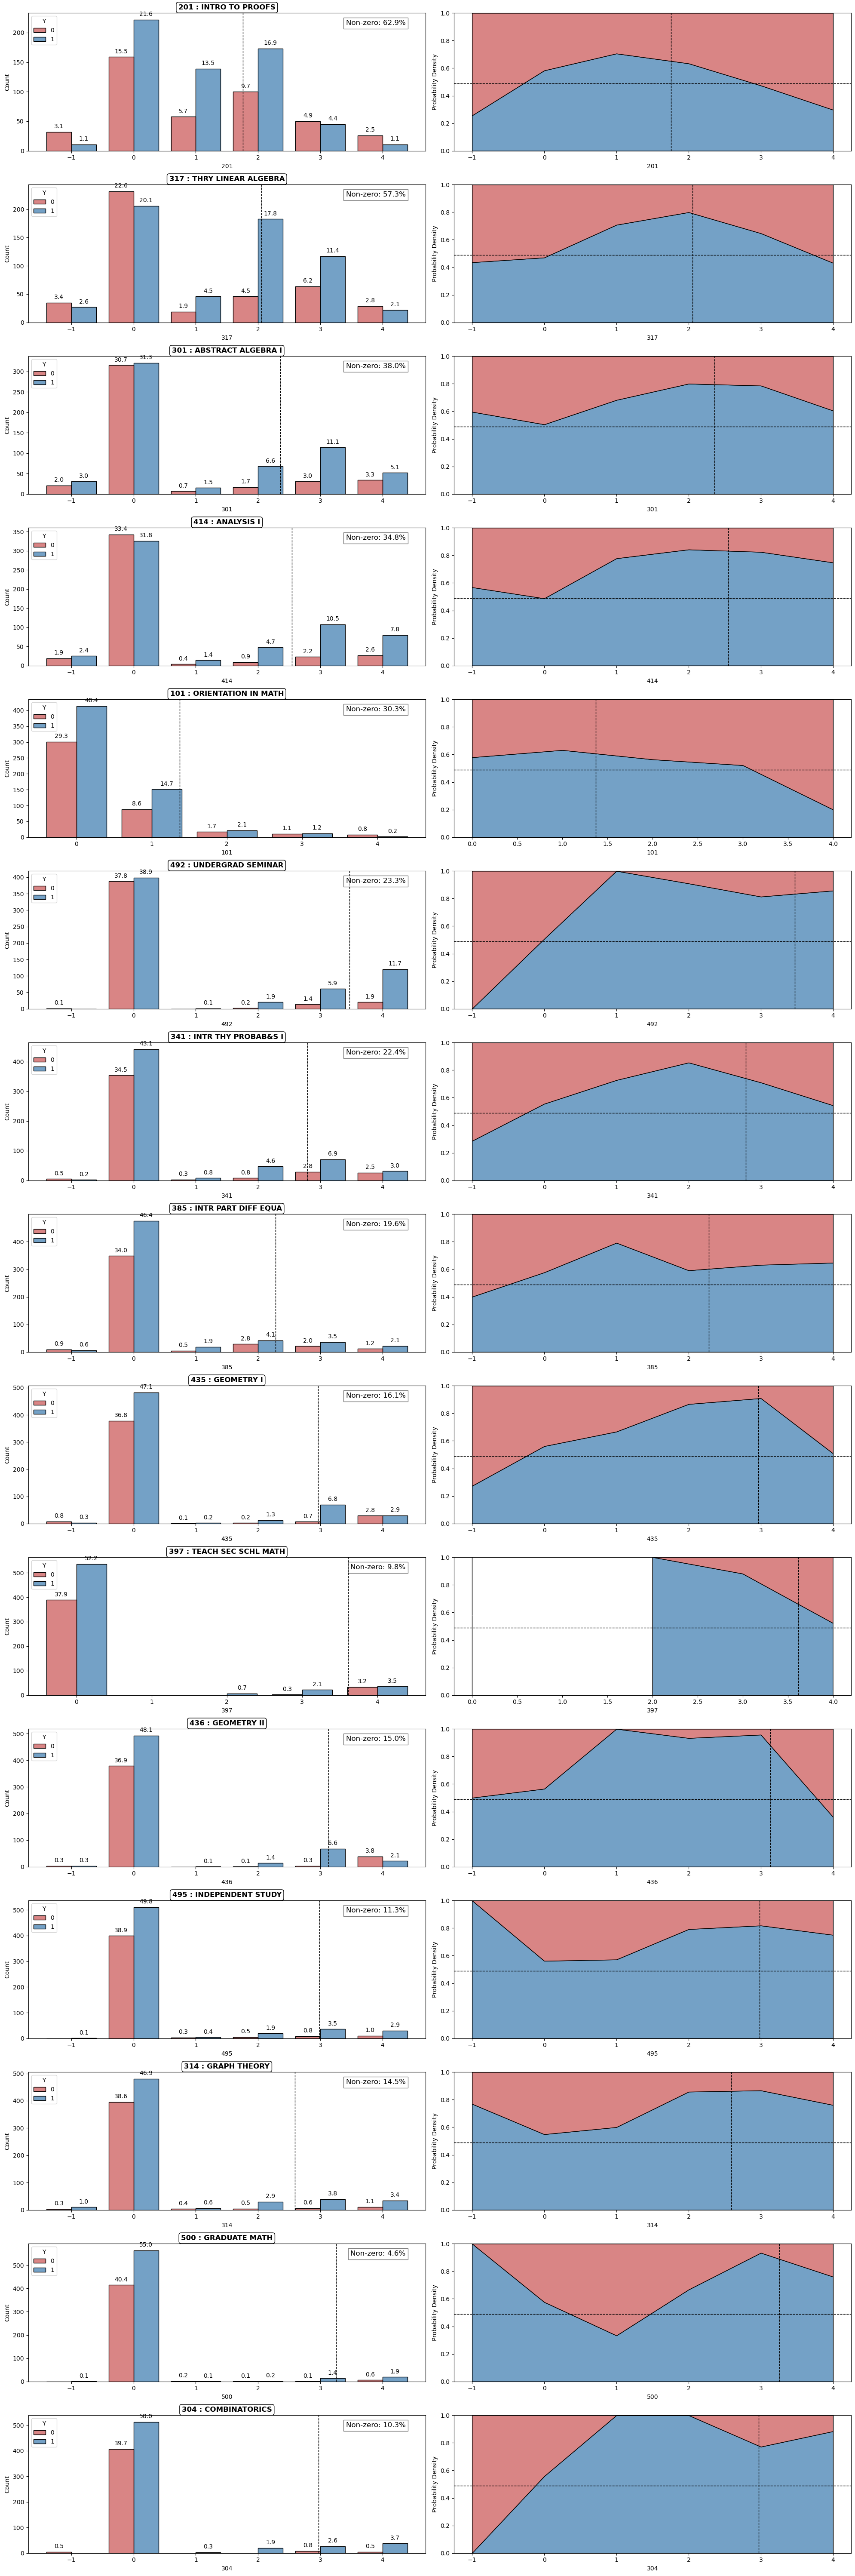

In [278]:
#concatenate the binary values of the courses to the original dataframe by replacing the original values of the courses with the binary values
# df[courses] = df_binary[courses]

#drop all of the 'SEM{i}_MATH_cdf' and 'SEM{i}_GEN_cdf' columns
df = df.drop(columns=[f'SEM{i}_MATH_cdf' for i in sems])
# df = df.drop(columns=[f'SEM{i}_GEN_cdf' for i in sems])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9181 entries, 0 to 9180
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STUDENT         9181 non-null   int64  
 1   ENT_SEM         9181 non-null   float64
 2   GRAD_SEM        9181 non-null   float64
 3   101             9181 non-null   float64
 4   104             9181 non-null   float64
 5   105             9181 non-null   float64
 6   140             9181 non-null   float64
 7   143             9181 non-null   float64
 8   150             9181 non-null   float64
 9   160             9181 non-null   float64
 10  165             9181 non-null   float64
 11  166             9181 non-null   float64
 12  201             9181 non-null   float64
 13  207             9181 non-null   float64
 14  25              9181 non-null   float64
 15  265             9181 non-null   float64
 16  266             9181 non-null   float64
 17  267             9181 non-null   f

In [130]:
#save the final dataframe to a csv file named 'dataset_engineered.csv' in the Data folder
df.to_csv('../Data/dataset_engineered.csv', index=False)

In [ ]:
years = [1, 2, 3, 4]

# Create a DataFrame for SEM columns
sem_df = pd.concat([df_copy[courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'YEAR{i}') for i in years], axis=1)
sem_math_df = pd.concat([df_copy[math_courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'YEAR{i}_MATH') for i in years], axis=1)
sem_gen_df = pd.concat([df_copy[gen_courses].apply(lambda x: x.tolist().count(i) - x.tolist().count(-i), axis=1).rename(f'YEAR{i}_GEN') for i in years], axis=1)

# Define columns for the cumulative sums of math performance
df_copy[[f'YEAR{i}_cdf' for i in years]] = sem_df.cumsum(axis=1)
df_copy[[f'YEAR{i}_MATH_cdf' for i in years]] = sem_math_df.cumsum(axis=1)
df_copy[[f'YEAR{i}_GEN_cdf' for i in years]] = sem_gen_df.cumsum(axis=1)

# Use the function animate_histograms to animate the histograms of the cumulative number of courses taken in each year
animate_histograms(data_series = [df_copy[f'YEAR{i}_cdf'] for i in years],
                     titles = [f'YEAR{i}_cdf' for i in years],
                     timeperiods=years,
                     suptitle = 'Overall course performance in year',
                     unique_values = sorted(df_copy['YEAR4_cdf'].unique())).save('cdf_animation_year.gif', writer='Pillow')

animate_histograms(data_series = [df_copy[f'YEAR{i}_MATH_cdf'] for i in years],
                     titles = [f'YEAR{i}_MATH_cdf' for i in years],
                        timeperiods=years,
                     suptitle = 'Math major course performance in year',
                     unique_values = sorted(df_copy['YEAR4_MATH_cdf'].unique())).save('cdf_animation_math_year.gif', writer='Pillow')

animate_histograms(data_series = [df_copy[f'YEAR{i}_GEN_cdf'] for i in years],
                     titles = [f'YEAR{i}_GEN_cdf' for i in years],
                        timeperiods=years,
                     suptitle = 'General course performance in year',
                     unique_values = sorted(df_copy['YEAR4_GEN_cdf'].unique())).save('cdf_animation_gen_year.gif', writer='Pillow')


df_copy['slp'] = 0.0
df_copy['int'] = 0.0
df_copy['slp_math'] = 0.0
df_copy['int_math'] = 0.0
df_copy['slp_gen'] = 0.0
df_copy['int_gen'] = 0.0

# Loop through the rows of the DataFrame
x = years
for i, row in df_copy.iterrows():
    # y values
    y = row[[f'YEAR{j}_cdf' for j in years]].astype(float)
    y_math = row[[f'YEAR{j}_MATH_cdf' for j in years]].astype(float)
    y_gen = row[[f'YEAR{j}_GEN_cdf' for j in years]].astype(float)
    # Calculate the slope and intercept
    S, I = np.polyfit(x, y, 1)
    S_math, I_math = np.polyfit(x, y_math, 1)
    S_gen, I_gen = np.polyfit(x, y_gen, 1)
    # Store the values in the original DataFrame
    df_copy.at[i, 'slp'] = S
    df_copy.at[i, 'int'] = I
    df_copy.at[i, 'slp_math'] = S_math
    df_copy.at[i, 'int_math'] = I_math
    df_copy.at[i, 'slp_gen'] = S_gen
    df_copy.at[i, 'int_gen'] = I_gen